# Data Preparation and Atom Embeddings

This notebook covers:
1. Generating elemental property JSON (atom_init.json)
2. Creating atom embedding configuration
3. Building atom embeddings from properties and configuration

**Purpose**: Create a lookup table of numerical embeddings for each element that can be used as node features in graph neural networks.

## Part 1: Generate Elemental Property Dictionary

We'll extract fundamental physical, chemical, and electronic properties for all known elements using pymatgen's Element class.

In [8]:
# Import required libraries
from pymatgen.core.periodic_table import Element
from collections import defaultdict
import warnings
import math
import json
import numpy as np

### Saving elemental Property as JSON
- We use JSON (JavaScript Object Notation) because it is a lightweight, human-readable format for storing and exchanging data.
- JSON works well for serializing complex data structures (like dictionaries and lists) making it ideal for saving, sharing, and loading structured information between applications.

### Verify Data - Example for Carbon

In [15]:
with open('elements.json', 'r') as f:
    elements_dict = json.load(f)
    print(elements_dict["H"])

{'Z': 1, 'group': 1, 'period': None, 'atomic_mass': 1.00794, 'covalent_radius': None, 'van_der_waals_radius': 1.1, 'pauling_electronegativity': 2.2, 'electron_affinity': 0.75419519, 'first_ionization_energy': 13.598434599702, 'valence_electrons': {'s': 1, 'p': 0, 'd': 0, 'f': 0}, 'is_metal': 0, 'block': 's', 'mendeleev_number': 103.0}


## Part 2: Create Atom Embedding Configuration

This configuration file defines how each elemental property should be encoded into ML-ready embeddings.

In [100]:
CONFIG_PATH = "atom_embed_config.json"

# Configuration for encoding each feature
# You can tweak this anytime and rebuild the embeddings
config = {
    # --- categorical/ordinal as one-hot ---
    "Z":            {"use": True,  "type": "onehot",  "size": 119},  # 0..118, use Z as index
    "group":        {"use": True,  "type": "onehot",  "size": 19},   # 0..18 (1..18 groups; 0=unknown)
    "period":       {"use": True,  "type": "onehot",  "size": 8},    # 0..7  (1..7 periods; 0=unknown)
    "block":        {"use": True,  "type": "onehot",  "categories": ["s","p","d","f"]},

    # --- continuous as Gaussian RBF (auto-range from data) ---
    "atomic_mass":             {"use": False,  "type": "gaussian", "bins": 32, "range": "auto"},
    "covalent_radius":         {"use": True,  "type": "gaussian", "bins": 32, "range": "auto"},
    "van_der_waals_radius":    {"use": False,  "type": "gaussian", "bins": 32, "range": "auto"},
    "pauling_electronegativity":{"use": False, "type": "gaussian", "bins": 32, "range": "auto"},
    "electron_affinity":       {"use": False,  "type": "gaussian", "bins": 32, "range": "auto"},
    "first_ionization_energy": {"use": False,  "type": "gaussian", "bins": 32, "range": "auto"},
    "mendeleev_number":        {"use": False,  "type": "gaussian", "bins": 32, "range": "auto"},

    # --- valence counts as linear scalars (you can switch to onehot later) ---
    "valence_s":   {"use": True,  "type": "linear"},
    "valence_p":   {"use": True,  "type": "linear"},
    "valence_d":   {"use": True,  "type": "linear"},
    "valence_f":   {"use": True,  "type": "linear"},

}

In [101]:
# Save configuration file
with open(CONFIG_PATH, "w") as f:
    json.dump(config, f, indent=2)

## Part 3: Build Atom Embeddings

- Building atom embeddings means creating fixed-length numerical vectors to represent the properties of each chemical element in a way that machine learning models can use.
- These embeddings combine atomic information (like group, period, valence electron counts, radii, electronegativity) using techniques such as one-hot encoding for categorical data and Gaussian basis expansion for continuous features.
- By carefully choosing and encoding these features, atom embeddings serve as informative inputs for models that predict material or crystal properties, enabling data-driven discovery in chemistry and materials science.

### Load Data and Configuration

In [16]:
# File paths
ATOM_INIT_PATH = "elements.json"
CONFIG_PATH    = "atom_embed_config.json"
EMB_PATH       = "atom_embedding.json"

In [22]:
# Load element properties
with open(ATOM_INIT_PATH, "r") as f:
    ELEMENTS = json.load(f)  # {symbol -> dict}

# Load configuration
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

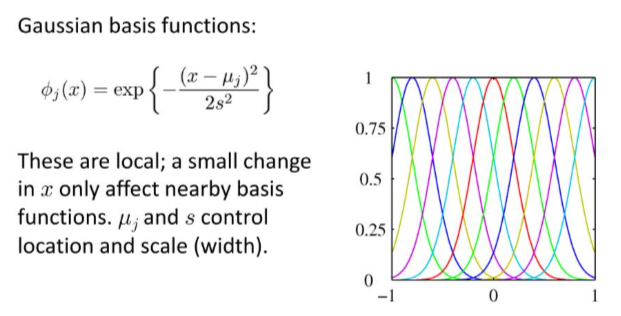

In [23]:
import numpy as np

# --- Build auto_ranges for Gaussian features ---
auto_ranges = {}
for key, spec in config.items():
    if spec.get("type") == "gaussian" and spec.get("range") == "auto":
        values = [el.get(key) for el in elements_dict.values() if el.get(key) is not None]
        if len(values) > 0:
            auto_ranges[key] = (min(values), max(values))
        else:
            auto_ranges[key] = (0, 1)  # Fallback if all values are missing

print("Auto ranges:", auto_ranges)

# --- Utility functions ---
def gaussian_expand(x, a, b, bins=32, s=None):
    """Gaussian (RBF) expansion for scalar values."""
    a = min(a, b)
    b = max(a, b)
    if s is None:
        s = (b - a) / bins
    centers = np.linspace(a, b, bins)
    if x is None:
        return np.zeros(bins)
    return np.exp(-((x - centers) ** 2) / (2 * (s ** 2)))

def onehot_encode(x, size=None, categories=None):
    if categories is not None:
        size = len(categories)
        v = [0] * size
        if x in categories:
            v[categories.index(x)] = 1
        return v
    elif size is not None:
        v = [0] * size
        if x is not None and 0 <= int(x) < size:
            v[int(x)] = 1
        return v
    else:
        raise ValueError("Must provide either size or categories for onehot encoding.")

def build_embedding(element_prop, config, auto_ranges):
    embedding = []
    for key, spec in config.items():
        if not spec.get("use", False):
            continue
        value = element_prop.get(key)
        # One-hot encoding
        if spec["type"] == "onehot":
            if "categories" in spec:
                emb = onehot_encode(value, categories=spec["categories"])
            elif "size" in spec:
                emb = onehot_encode(value, size=spec["size"])
            else:
                raise ValueError(f"No categories or size defined for onehot encoding key: {key}")
        # Gaussian basis encoding
        elif spec["type"] == "gaussian":
            bounds = auto_ranges[key] if spec.get("range", None) == "auto" else (spec["min"], spec["max"])
            emb = gaussian_expand(value, bounds[0], bounds[1], bins=spec["bins"])
        # Linear encoding
        elif spec["type"] == "linear":
            emb = [value if value is not None else 0]
        else:
            raise ValueError(f"Unknown feature type for key {key}")
        embedding.extend(emb)
    return np.array(embedding)


Auto ranges: {'atomic_mass': (1.00794, 294.0), 'covalent_radius': (0, 1), 'van_der_waals_radius': (1.1, 3.48), 'pauling_electronegativity': (0.7, 3.98), 'electron_affinity': (-2.33, 3.61272528), 'first_ionization_energy': (3.89390572743, 65.0), 'mendeleev_number': (1.0, 103.0)}


### Core Encoder Function

### Build Embeddings for All Elements

In [24]:
embedding_dict = {}
for symbol, prop in elements_dict.items():
    embedding_dict[symbol] = build_embedding(prop, config, auto_ranges)

# Print embedding for one element, e.g., Iron
print("Embedding length for Fe:", len(embedding_dict["Fe"]))
print("\nEmbedding for Fe:", embedding_dict["Fe"])

Embedding length for Fe: 186

Embedding for Fe: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [25]:
# Sanity check
emb_len = len(embedding_dict["H"])

assert all(len(v) == emb_len for v in embedding_dict.values()), "Inconsistent embedding length!"

print("All embeddings have consistent length")

All embeddings have consistent length


### Save Embedding Lookup Table

In [26]:
# all embeddings from numpy arrays to Python lists
embedding_dict_to_save = {k: v.tolist() for k, v in embedding_dict.items()}

# Save embedding lookup table
with open(EMB_PATH, "w") as f:
    json.dump({"embedding_length": emb_len, "embeddings": embedding_dict_to_save}, f, indent=2)

print(f"Saved '{EMB_PATH}' with {len(embedding_dict)} symbols; embedding_length = {emb_len}")


Saved 'atom_embedding.json' with 118 symbols; embedding_length = 186


## Summary

We have successfully:
1. ✅ Extracted elemental properties for 118 elements → `elements.json`
2. ✅ Created encoding configuration → `atom_embed_config.json`
3. ✅ Generated numeric embeddings → `atom_embedding.json`

These embeddings can now be used as node features in graph neural networks for materials property prediction.